In [1]:
# 데이터 불러오기
import pandas as pd
train = pd.read_csv('../Data/orb_data/train.csv', index_col=0)
test = pd.read_csv('../Data/orb_data/test.csv', index_col=0)
sample_submission = pd.read_csv('../Data/orb_data/sample_submission.csv', index_col=0)

In [2]:
# Train 데이터의 타입을 Sample_submission에 대응하는 가변수 형태로 변환
column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

train['type_num'] = train['type'].apply(lambda x : to_number(x, column_number))

In [ ]:
# 히트맵 그리기
%matplotlibplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 15))
sns.heatmap(data=train.corr(), annot=True)
plt.show()

In [3]:
# 모델에 적용할 데이터 셋 준비 
train_x = train.drop(columns=['type', 'type_num'], axis=1)
train_y = train['type_num']
test_x = test # (10009, 20)

In [4]:
# FiberID 행 지우기
del train_x['fiberID']
del test_x['fiberID']

In [5]:
train_x.columns

Index(['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z',
       'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i', 'fiberMag_z',
       'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i', 'petroMag_z',
       'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z'],
      dtype='object')

In [6]:
test_x.columns

Index(['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z',
       'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i', 'fiberMag_z',
       'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i', 'petroMag_z',
       'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z'],
      dtype='object')

In [7]:
# 훈련 데이터와 테스트 데이터로 나누기
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2)

# One-Hot Encoding
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [8]:
# 데이터 스케일
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
test_x = scaler.transform(test_x)

In [9]:
# 모델 구성
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()

model.add(Dense(512, input_shape=(20,)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(19, activation='softmax'))

In [10]:
# 모델 요약
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               10752     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 128)              

In [11]:
# 조기 종료
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=100)

In [12]:
# 컴파일
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# Adam optimizer default: keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

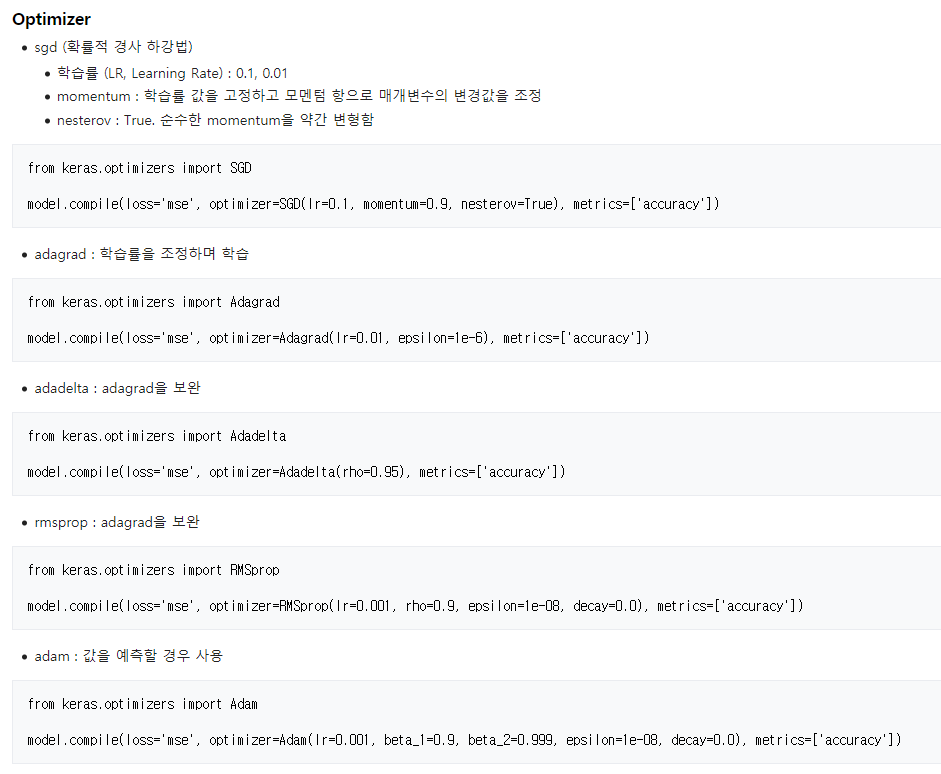

In [13]:
# 훈련
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10000, batch_size=128, callbacks=[early_stopping]) # epochs number changeable


Train on 127993 samples, validate on 31999 samples
Epoch 1/10000
127993/127993 [==============================] - 3s 26us/step - loss: 1.3300 - accuracy: 0.5692 - val_loss: 0.7818 - val_accuracy: 0.7542
Epoch 2/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.7943 - accuracy: 0.7492 - val_loss: 0.6853 - val_accuracy: 0.7609
Epoch 3/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.6707 - accuracy: 0.7680 - val_loss: 0.6394 - val_accuracy: 0.7767
Epoch 4/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.6244 - accuracy: 0.7827 - val_loss: 0.6171 - val_accuracy: 0.7829
Epoch 5/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.5985 - accuracy: 0.7907 - val_loss: 0.5764 - val_accuracy: 0.7994
Epoch 6/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.5609 - accuracy: 0.8088 - val_loss: 0.5358 - val_accuracy: 0.8228
Epoch 7/10000
127993/127993 [=======

Epoch 53/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.4014 - accuracy: 0.8616 - val_loss: 0.4021 - val_accuracy: 0.8614
Epoch 54/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3958 - accuracy: 0.8627 - val_loss: 0.3975 - val_accuracy: 0.8614
Epoch 55/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3942 - accuracy: 0.8615 - val_loss: 0.4049 - val_accuracy: 0.8587
Epoch 56/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.4033 - accuracy: 0.8615 - val_loss: 0.4101 - val_accuracy: 0.8574
Epoch 57/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.4002 - accuracy: 0.8611 - val_loss: 0.3937 - val_accuracy: 0.8638
Epoch 58/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3941 - accuracy: 0.8626 - val_loss: 0.4048 - val_accuracy: 0.8625
Epoch 59/10000
127993/127993 [==============================] - 3s 23us/step - los

127993/127993 [==============================] - 3s 23us/step - loss: 0.4252 - accuracy: 0.8676 - val_loss: 0.4036 - val_accuracy: 0.8641
Epoch 107/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3669 - accuracy: 0.8696 - val_loss: 0.3986 - val_accuracy: 0.8646
Epoch 108/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3672 - accuracy: 0.8697 - val_loss: 0.4148 - val_accuracy: 0.8579
Epoch 109/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3668 - accuracy: 0.8700 - val_loss: 0.4044 - val_accuracy: 0.8623
Epoch 110/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3692 - accuracy: 0.8696 - val_loss: 0.3993 - val_accuracy: 0.8642
Epoch 111/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3654 - accuracy: 0.8703 - val_loss: 0.4008 - val_accuracy: 0.8639
Epoch 112/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3771

127993/127993 [==============================] - 3s 23us/step - loss: 0.3541 - accuracy: 0.8739 - val_loss: 0.4179 - val_accuracy: 0.8622
Epoch 160/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3537 - accuracy: 0.8736 - val_loss: 0.4134 - val_accuracy: 0.8609
Epoch 161/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3568 - accuracy: 0.8731 - val_loss: 0.4220 - val_accuracy: 0.8620
Epoch 162/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3547 - accuracy: 0.8736 - val_loss: 0.4068 - val_accuracy: 0.8669
Epoch 163/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3578 - accuracy: 0.8732 - val_loss: 0.4235 - val_accuracy: 0.8599
Epoch 164/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3523 - accuracy: 0.8748 - val_loss: 0.3989 - val_accuracy: 0.8664
Epoch 165/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3563

127993/127993 [==============================] - 3s 23us/step - loss: 0.3421 - accuracy: 0.8781 - val_loss: 0.4123 - val_accuracy: 0.8653
Epoch 213/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3421 - accuracy: 0.8773 - val_loss: 0.4134 - val_accuracy: 0.8617
Epoch 214/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3507 - accuracy: 0.8770 - val_loss: 0.4203 - val_accuracy: 0.8599
Epoch 215/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3473 - accuracy: 0.8760 - val_loss: 0.4115 - val_accuracy: 0.8636
Epoch 216/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3460 - accuracy: 0.8764 - val_loss: 0.4178 - val_accuracy: 0.8653
Epoch 217/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3450 - accuracy: 0.8770 - val_loss: 0.4174 - val_accuracy: 0.8621
Epoch 218/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3584

127993/127993 [==============================] - 3s 23us/step - loss: 0.3422 - accuracy: 0.8782 - val_loss: 0.4203 - val_accuracy: 0.8650
Epoch 266/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3857 - accuracy: 0.8765 - val_loss: 0.4194 - val_accuracy: 0.8643
Epoch 267/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3443 - accuracy: 0.8772 - val_loss: 0.4131 - val_accuracy: 0.8651
Epoch 268/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3401 - accuracy: 0.8788 - val_loss: 0.4119 - val_accuracy: 0.8652
Epoch 269/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3373 - accuracy: 0.8783 - val_loss: 0.4262 - val_accuracy: 0.8645
Epoch 270/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3388 - accuracy: 0.8790 - val_loss: 0.4204 - val_accuracy: 0.8639
Epoch 271/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.8505

127993/127993 [==============================] - 3s 23us/step - loss: 0.3329 - accuracy: 0.8809 - val_loss: 0.4267 - val_accuracy: 0.8657
Epoch 319/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3406 - accuracy: 0.8787 - val_loss: 0.4542 - val_accuracy: 0.8647
Epoch 320/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3432 - accuracy: 0.8777 - val_loss: 0.4357 - val_accuracy: 0.8629
Epoch 321/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3401 - accuracy: 0.8794 - val_loss: 0.4402 - val_accuracy: 0.8606
Epoch 322/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3349 - accuracy: 0.8802 - val_loss: 0.4327 - val_accuracy: 0.8619
Epoch 323/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3369 - accuracy: 0.8785 - val_loss: 0.4672 - val_accuracy: 0.8642
Epoch 324/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3386

127993/127993 [==============================] - 3s 23us/step - loss: 0.3361 - accuracy: 0.8799 - val_loss: 0.4391 - val_accuracy: 0.8628
Epoch 372/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3306 - accuracy: 0.8812 - val_loss: 0.4501 - val_accuracy: 0.8610
Epoch 373/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3351 - accuracy: 0.8803 - val_loss: 0.4399 - val_accuracy: 0.8611
Epoch 374/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3593 - accuracy: 0.8791 - val_loss: 0.4284 - val_accuracy: 0.8647
Epoch 375/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3389 - accuracy: 0.8800 - val_loss: 0.4404 - val_accuracy: 0.8625
Epoch 376/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3391 - accuracy: 0.8786 - val_loss: 0.9363 - val_accuracy: 0.8643
Epoch 377/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3327

127993/127993 [==============================] - 3s 23us/step - loss: 0.3308 - accuracy: 0.8822 - val_loss: 0.4554 - val_accuracy: 0.8683
Epoch 425/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3307 - accuracy: 0.8815 - val_loss: 0.4745 - val_accuracy: 0.8606
Epoch 426/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3319 - accuracy: 0.8805 - val_loss: 0.4467 - val_accuracy: 0.8657
Epoch 427/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3269 - accuracy: 0.8824 - val_loss: 0.4805 - val_accuracy: 0.8647
Epoch 428/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3390 - accuracy: 0.8804 - val_loss: 0.5120 - val_accuracy: 0.8337
Epoch 429/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3428 - accuracy: 0.8786 - val_loss: 0.4529 - val_accuracy: 0.8649
Epoch 430/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3330

127993/127993 [==============================] - 3s 23us/step - loss: 0.3280 - accuracy: 0.8827 - val_loss: 1.0502 - val_accuracy: 0.8640
Epoch 478/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3912 - accuracy: 0.8680 - val_loss: 1.1712 - val_accuracy: 0.8627
Epoch 479/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3342 - accuracy: 0.8803 - val_loss: 0.4461 - val_accuracy: 0.8619
Epoch 480/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3299 - accuracy: 0.8820 - val_loss: 0.4275 - val_accuracy: 0.8674
Epoch 481/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3234 - accuracy: 0.8841 - val_loss: 0.5701 - val_accuracy: 0.8650
Epoch 482/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3413 - accuracy: 0.8837 - val_loss: 0.8526 - val_accuracy: 0.8660
Epoch 483/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3244

127993/127993 [==============================] - 3s 23us/step - loss: 0.3263 - accuracy: 0.8834 - val_loss: 0.4413 - val_accuracy: 0.8652
Epoch 531/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3326 - accuracy: 0.8816 - val_loss: 0.4743 - val_accuracy: 0.8659
Epoch 532/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.4608 - accuracy: 0.8474 - val_loss: 0.4788 - val_accuracy: 0.8533
Epoch 533/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3968 - accuracy: 0.8655 - val_loss: 0.4252 - val_accuracy: 0.8605
Epoch 534/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3770 - accuracy: 0.8714 - val_loss: 0.4355 - val_accuracy: 0.8613
Epoch 535/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3432 - accuracy: 0.8781 - val_loss: 0.4308 - val_accuracy: 0.8649
Epoch 536/10000
127993/127993 [==============================] - 3s 23us/step - loss: 0.3392

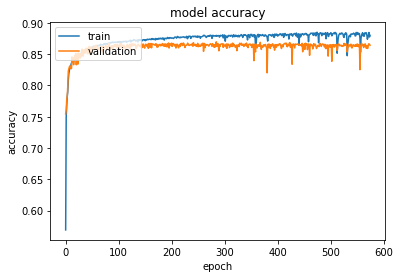

In [18]:
# summarize history for accuracy
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

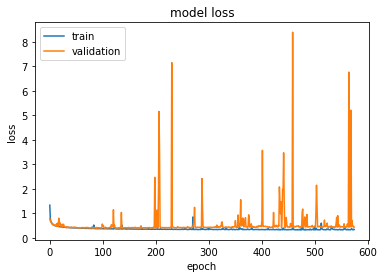

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [20]:
# 평가예측
loss, accuracy = model.evaluate(X_test, y_test, batch_size=128)
print('loss: ', loss)
print('accuracy: ', accuracy)

39999/39999 [==============================] - 0s 7us/step
loss:  0.45499459261977554
accuracy:  0.8633465766906738


In [21]:
# Evaluating in optimal parameter
y_pred = model.predict(test_x)
print(y_pred)

[[2.4951164e-32 5.1295968e-17 9.0513495e-05 ... 0.0000000e+00
  3.5234345e-05 1.9559395e-12]
 [4.8816952e-07 9.8904579e-08 2.3304032e-29 ... 1.2178665e-36
  8.9921008e-11 2.7901790e-06]
 [3.5345238e-06 6.4218575e-06 0.0000000e+00 ... 5.7175218e-23
  1.8756347e-13 2.5655244e-12]
 ...
 [1.0899541e-03 7.5321204e-06 0.0000000e+00 ... 0.0000000e+00
  4.6600081e-07 7.9608805e-02]
 [2.7555012e-18 1.2981823e-22 0.0000000e+00 ... 0.0000000e+00
  1.7104583e-12 6.1926090e-05]
 [2.3665071e-04 1.4103883e-05 0.0000000e+00 ... 8.6088626e-15
  4.3917122e-08 3.1721149e-07]]


In [22]:
# 제출 파일 생성
submission = pd.DataFrame(data=y_pred, columns=sample_submission.columns, index=sample_submission.index)
submission.to_csv('submission.csv', index=True)

# 결과 분석 

제출 결과 0.49505의 점수로 정확도는 높으나 실제로는 overfitting이 일어나는 것 같습니다. 

그래서 overfitting을 줄여주는 기법들을 써서 실제 정확도를 높이겠습니다.

출처: https://everyday-deeplearning.tistory.com/entry/%ED%8C%8C%EC%9D%B4%EC%8D%AC%EC%9C%BC%EB%A1%9C-%EB%94%A5%EB%9F%AC%EB%8B%9D%ED%95%98%EA%B8%B0-%EC%8B%A0%EA%B2%BD%EB%A7%9D-%ED%95%99%EC%8A%B5%EC%9D%98-%ED%9A%A8%EC%9C%A8%EA%B3%BC-%EC%A0%95%ED%99%95%EB%8F%84-%EC%98%AC%EB%A6%AC%EA%B8%B0